In [2]:
pip install "bertopic[all]"


Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

# 1. Nuskaitom tavo failą
df = pd.read_csv("bbc_news.csv")  

df.head()

,title,pubDate,guid,link,description
0,Ukraine: Angry Zelensky vows to punish Russian...,"Mon, 07 Mar 2022 08:01:56 GMT",https://www.bbc.co.uk/news/world-europe-60638042,https://www.bbc.co.uk/news/world-europe-606380...,The Ukrainian president says the country will ...
1,War in Ukraine: Taking cover in a town under a...,"Sun, 06 Mar 2022 22:49:58 GMT",https://www.bbc.co.uk/news/world-europe-60641873,https://www.bbc.co.uk/news/world-europe-606418...,"Jeremy Bowen was on the frontline in Irpin, as..."
2,Ukraine war 'catastrophic for global food',"Mon, 07 Mar 2022 00:14:42 GMT",https://www.bbc.co.uk/news/business-60623941,https://www.bbc.co.uk/news/business-60623941?a...,One of the world's biggest fertiliser firms sa...
3,Manchester Arena bombing: Saffie Roussos's par...,"Mon, 07 Mar 2022 00:05:40 GMT",https://www.bbc.co.uk/news/uk-60579079,https://www.bbc.co.uk/news/uk-60579079?at_medi...,The parents of the Manchester Arena bombing's ...
4,Ukraine conflict: Oil price soars to highest l...,"Mon, 07 Mar 2022 08:15:53 GMT",https://www.bbc.co.uk/news/business-60642786,https://www.bbc.co.uk/news/business-60642786?a...,Consumers are feeling the impact of higher ene...


In [4]:
# 2. Sukuriam vieną tekstinį stulpelį:
#   title + description (jei description trūksta - panaudojam tik title)

df["description"] = df["description"].fillna("")
df["title"] = df["title"].fillna("")

df["text"] = df["title"] + ". " + df["description"]
texts = df["text"].tolist()

len(texts), texts[0]


(42115,
 'Ukraine: Angry Zelensky vows to punish Russian atrocities. The Ukrainian president says the country will not forgive or forget those who murder its civilians.')

In [5]:
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

def train_bertopic_with_embedding(texts, embed_model_name, nr_topics=6,
                                  min_topic_size=50):
    """
    texts            - dokumentų sąrašas (string'ai)
    embed_model_name - sentence-transformer modelio pavadinimas
    nr_topics        - kiek temų norim gauti
    min_topic_size   - minimali dokumentų skaičiaus riba temai
    """
    print(f"\n=== Treniruojame su embedding: {embed_model_name} ===")
    sentence_model = SentenceTransformer(embed_model_name)

    vectorizer_model = CountVectorizer(stop_words="english")  

    topic_model = BERTopic(
        embedding_model=sentence_model,
        nr_topics=nr_topics,
        min_topic_size=min_topic_size,
        language="english",
        calculate_probabilities=True,
        verbose=True,
        vectorizer_model=vectorizer_model  # <-- aktyvuojame stop-wordų šalinimą
    )

    topics, probs = topic_model.fit_transform(texts)
    return topic_model, topics, probs


In [6]:
#Pirmas modelis:
embed_model_1 = "all-MiniLM-L6-v2"

topic_model_1, topics_1, probs_1 = train_bertopic_with_embedding(
    texts,
    embed_model_name=embed_model_1,
    nr_topics=6,
    min_topic_size=50
)



=== Treniruojame su embedding: all-MiniLM-L6-v2 ===


2025-11-23 18:50:22,581 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/1317 [00:00<?, ?it/s]

2025-11-23 18:51:05,216 - BERTopic - Embedding - Completed ✓
2025-11-23 18:51:05,217 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2025-11-23 18:51:19,100 - BERTopic - Dimensionality - Completed ✓
2025-11-23 18:51:19,102 - BERTopic - Cluster - Start clustering the reduced embeddings
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the

In [9]:
# Bendroji informacija apie temas
topic_info_1 = topic_model_1.get_topic_info()
topic_info_1

,Topic,Count,Name,Representation,Representative_Docs
0,-1,15827,-1_says_bbc_police_new,"[says, bbc, police, new, people, year, league,...","[Liverpool & Man City: Two teams, three trophi..."
1,0,10349,0_ukraine_war_russia_russian,"[ukraine, war, russia, russian, israel, gaza, ...",[Ukraine war: Zelensky makes plea for US aid a...
2,1,8291,1_world_england_cup_win,"[world, england, cup, win, final, women, leagu...",[Wheelchair Rugby League World Cup: Tom Halliw...
3,2,3923,2_trump_queen_papers_king,"[trump, queen, papers, king, election, sunak, ...",[The Papers: 'Here comes the Sunak' and 'We mu...
4,3,3181,3_energy_strike_uk_strikes,"[energy, strike, uk, strikes, rates, says, cov...",[What is the UK inflation rate and why is the ...
5,4,544,4_ai_musk_tiktok_twitter,"[ai, musk, tiktok, twitter, elon, social, tech...",[Elon Musk strikes deal to buy Twitter for $44...


In [10]:
for topic_id in range(6):
    print(f"\n=== Tema {topic_id} ===")
    print(topic_model_1.get_topic(topic_id))   



=== Tema 0 ===
[('ukraine', np.float64(0.056450471565295576)), ('war', np.float64(0.04220370390814752)), ('russia', np.float64(0.034242494835321394)), ('russian', np.float64(0.028682006110114164)), ('israel', np.float64(0.028655716583363126)), ('gaza', np.float64(0.02825721514111809)), ('says', np.float64(0.028177230488335703)), ('uk', np.float64(0.023442943692214793)), ('people', np.float64(0.01916858105746608)), ('bbc', np.float64(0.01845137968619272))]

=== Tema 1 ===
[('world', np.float64(0.05960684632707247)), ('england', np.float64(0.0590835659719391)), ('cup', np.float64(0.05119392357898416)), ('win', np.float64(0.03604890411539038)), ('final', np.float64(0.032691179592167004)), ('women', np.float64(0.024311823518496988)), ('league', np.float64(0.024295544732768435)), ('2022', np.float64(0.024111234691940105)), ('says', np.float64(0.022158965534491388)), ('open', np.float64(0.020101080790032255))]

=== Tema 2 ===
[('trump', np.float64(0.051743777664304796)), ('queen', np.float6

In [11]:
# temai 0 pažiūrėti kelis tekstus
topic_id = 0
docs_in_topic_0 = [texts[i] for i, t in enumerate(topics_1) if t == topic_id]

len(docs_in_topic_0)
docs_in_topic_0[:5]  # pirmos 5 naujienos temoje 0


['Ukraine: Angry Zelensky vows to punish Russian atrocities. The Ukrainian president says the country will not forgive or forget those who murder its civilians.',
 'War in Ukraine: Taking cover in a town under attack. Jeremy Bowen was on the frontline in Irpin, as residents came under Russian fire while trying to flee.',
 "Ukraine war 'catastrophic for global food'. One of the world's biggest fertiliser firms says the conflict could deliver a shock to food supplies.",
 'Ukraine conflict: Oil price soars to highest level since 2008. Consumers are feeling the impact of higher energy costs as fuel prices and household bills jump.',
 'Ukraine war: PM to hold talks with world leaders on further sanctions. Boris Johnson is to meet the Canadian and Dutch PMs, as MPs debate new laws targeting oligarchs.']

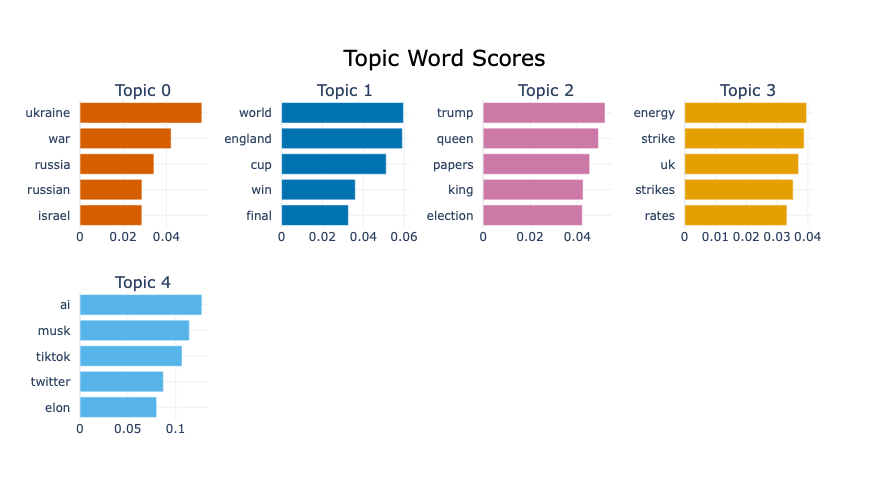

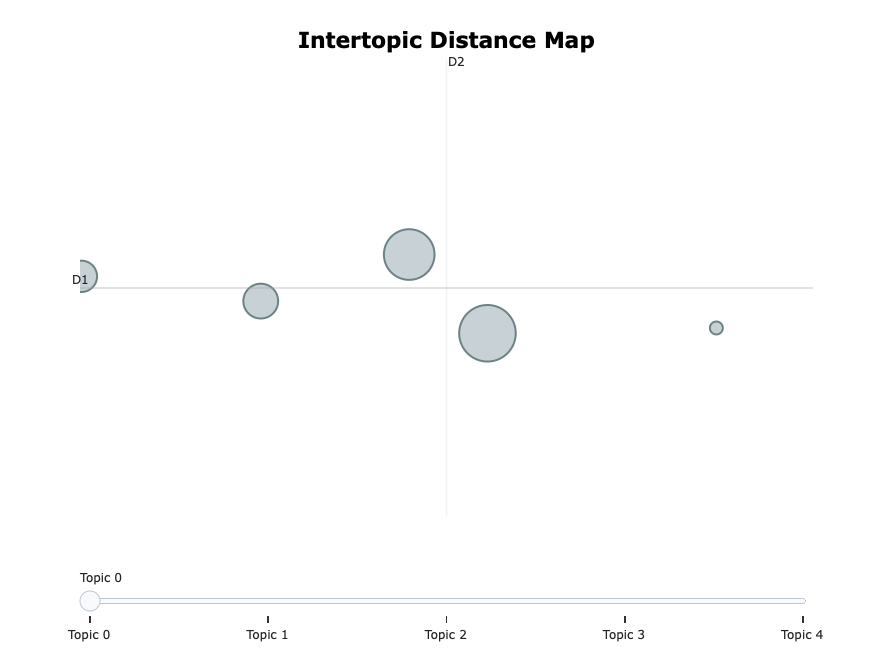

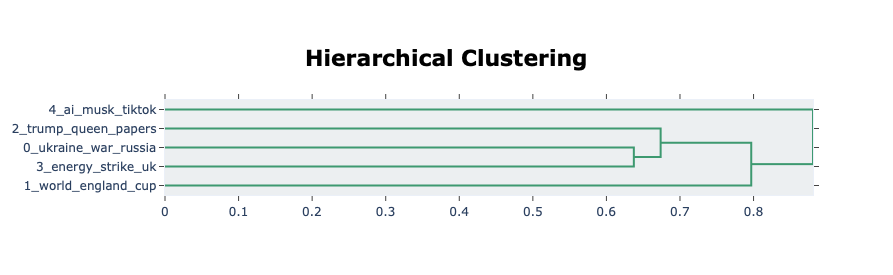

In [12]:
# Barchart – kiekvienos temos dažniausi žodžiai
fig_bar = topic_model_1.visualize_barchart(top_n_topics=7)
fig_bar.show()

# 2D projekcija (UMAP)
fig_topics = topic_model_1.visualize_topics()
fig_topics.show()

# Temų hierarchija
fig_h = topic_model_1.visualize_hierarchy()
fig_h.show()


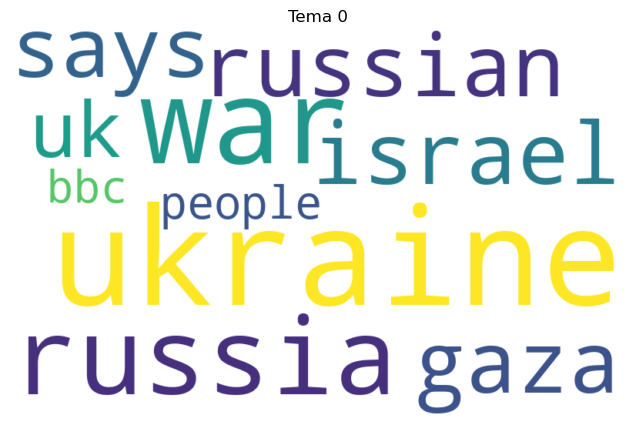

<Figure size 1200x800 with 0 Axes>

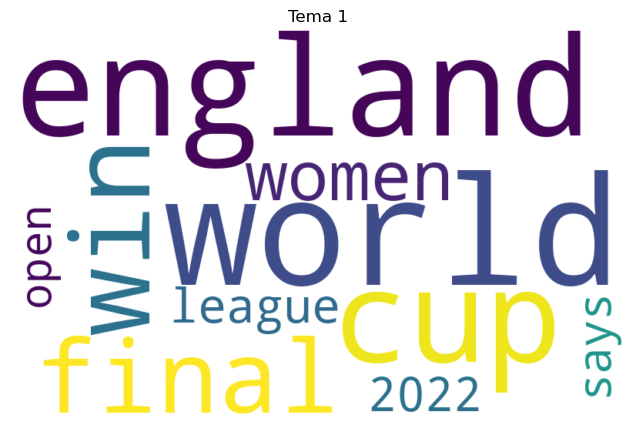

<Figure size 1200x800 with 0 Axes>

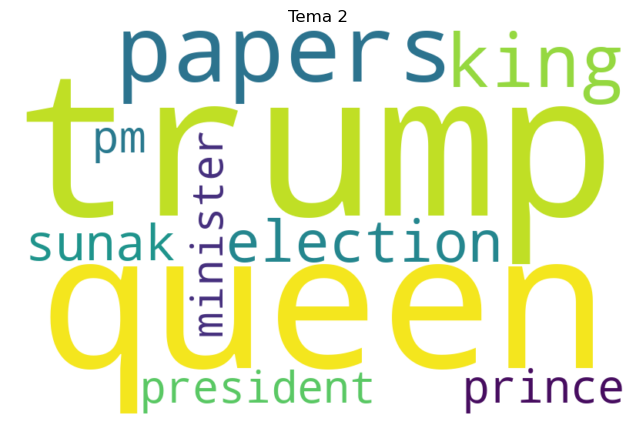

<Figure size 1200x800 with 0 Axes>

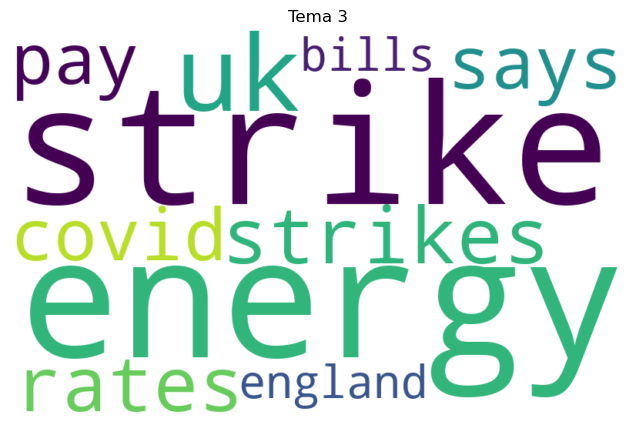

<Figure size 1200x800 with 0 Axes>

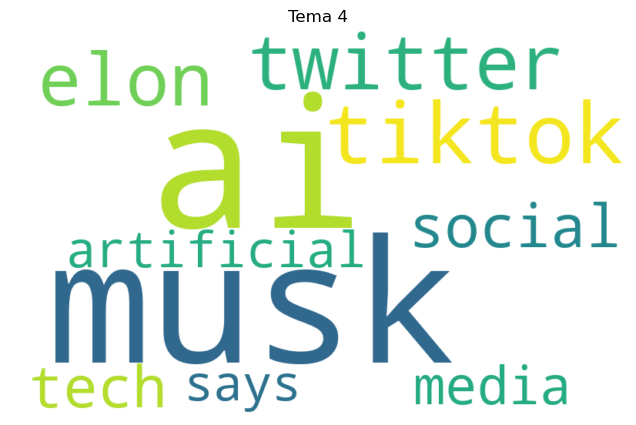

NameError: name 'wordcloud' is not defined

<Figure size 1200x800 with 0 Axes>

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

topics = topic_model_1.get_topics()

for topic_num in topics:
    if topic_num == -1:
        continue  # praleidžiam outlier cluster

    words = topic_model_1.get_topic(topic_num)
    word_freq = {w: v for w, v in words}

    wc = WordCloud(width=800, height=500, background_color="white")
    wc = wc.generate_from_frequencies(word_freq)

    plt.figure(figsize=(9, 5))
    plt.title(f"Tema {topic_num}")
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    plt.figure(figsize=(12, 8))
plt.imshow(wordcloud)
plt.axis("off")

import os
os.getcwd()
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud)  # or your Matplotlib figure
plt.axis("off")
